In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from tqdm import trange

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = datasets.CIFAR10(
    root='../data',
    download=False,
    train=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='../data',
    download=False,
    train=False,
    transform=transform
)

In [6]:
def add_noise(image: torch.Tensor, noise_level=0.01):
    if len(image.shape) == 3:
        image = image.unsqueeze(dim=0)
    
    noisy_image = image.clone()
    _, c, h, w = image.shape
    total_pixels = c * h * w
    total_noisy_pixels = int(noise_level * total_pixels)

    noisy_pixel_indices = torch.randint(0, total_pixels, (total_noisy_pixels,))

    noisy_pixels_c = noisy_pixel_indices // (h * w)
    noisy_pixels_h = (noisy_pixel_indices % (h * w)) // w
    noisy_pixels_w = noisy_pixel_indices % w

    noisy_image[:, noisy_pixels_c, noisy_pixels_h, noisy_pixels_w] = torch.clamp(
        noisy_image[:, noisy_pixels_c, noisy_pixels_h, noisy_pixels_w] - 1, min=0, max=1
    )

    return noisy_image

In [7]:
def display_single_image(image: torch.Tensor, noise_level=0.01):
    fig, axes = plt.subplots(1, 2, figsize=(3, 3))
    
    axes = axes.flatten()

    image_noisy = add_noise(image, noise_level)

    axes[0].imshow(image_noisy.squeeze().permute(1, 2, 0))
    axes[1].imshow(image.squeeze().permute(1, 2, 0))
    axes[0].axis('off')
    axes[1].axis('off')
    plt.show()

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

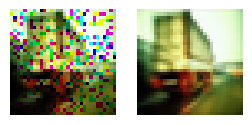

In [9]:
random_idx = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

display_single_image(train_dataset[random_idx][0], noise_level=0.2)

In [10]:
class DAE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return self.sigmoid(out)

In [11]:
def train_epoch(model: DAE, dataloader: DataLoader, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam, noise_level):
    size = len(dataloader.dataset)
    total_loss = 0
    model.train()

    for batch, (image, _) in enumerate(dataloader):
        image: torch.Tensor

        image = image.to(device)
        noisy_image = add_noise(image, noise_level).to(device)

        logits: torch.Tensor = model(noisy_image)

        loss: torch.Tensor = loss_fn(logits, image)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / size
    return avg_loss


def test_epoch(model: DAE, dataloader: DataLoader, loss_fn: nn.MSELoss, noise_level):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0

    with torch.no_grad():
        for image, _ in dataloader:
            image: torch.Tensor

            image = image.to(device)

            noisy_image = add_noise(image, noise_level)

            logits: torch.Tensor = model(noisy_image)

            loss: torch.TensorBase = loss_fn(logits, image)
            total_loss += loss.item()

    avg_loss = total_loss / size
    return avg_loss

In [12]:
def train(model: DAE, train_loader: DataLoader, test_loader: DataLoader, n_epoches=10, lr=0.01, noise_level=0.01):

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    saves = {'train_loss': [], 'test_loss': []}

    for epoch in (pbar := trange(n_epoches)):
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, noise_level=noise_level)
        test_loss = test_epoch(model, test_loader, loss_fn, noise_level=noise_level)

        pbar.set_description(f'Epoch {epoch + 1} | train loss {train_loss} | test loss {test_loss}')

        saves['train_loss'].append(train_loss)
        saves['test_loss'].append(test_loss)
    return saves

In [13]:
model = DAE().to(device)
saves = train(model, train_dataloader, test_dataloader, n_epoches=60, lr=0.01, noise_level=0.1)

Epoch 60 | train loss 4.642595374025405e-06 | test loss 4.189865686930716e-06: 100%|██████████| 60/60 [11:38<00:00, 11.65s/it]  


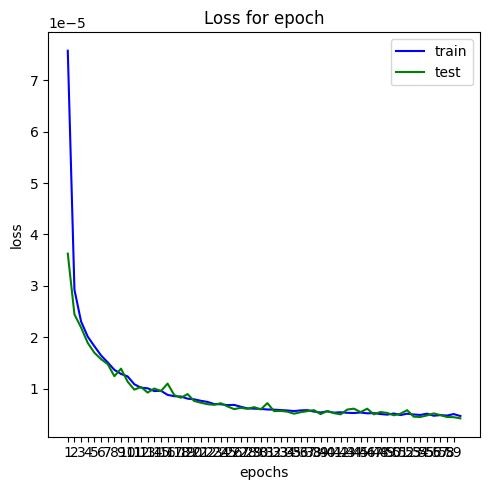

In [15]:
n_epoches = np.arange(len(saves['train_loss'])).astype(int) + 1

train_loss = saves['train_loss']
test_loss = saves['test_loss']

plt.figure(figsize=(5, 5))
plt.plot(n_epoches, train_loss, c='blue', label='train')
plt.plot(n_epoches, test_loss, c='green', label='test')
plt.title('Loss for epoch')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(1, len(saves['train_loss'])))
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def display_image_noise_recon(model: DAE, image: torch.Tensor, noise_level=0.01):
    fig, axes = plt.subplots(1, 3, figsize=(3, 3))

    noisy_image: torch.Tensor = add_noise(image, noise_level=noise_level)
    recon: torch.Tensor = model(noisy_image.to(device))

    axes[0].imshow(image.permute(1, 2, 0))
    axes[1].imshow(noisy_image.squeeze().permute(1, 2, 0))
    axes[2].imshow(recon.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    for i in range(3):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
def show_model(model: DAE, dataset: datasets.CIFAR10, noise_level=0.01):
    random_idx = torch.randint(low=0, high=len(dataset), size=(1,))

    image, _ = dataset[random_idx]

    display_image_noise_recon(model, image, noise_level)

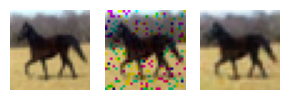

In [18]:
show_model(model, test_dataset, noise_level=0.1)